Index(['DateTime', 'EnergyConsumption(kWh)'], dtype='object')
Index(['DateTime'], dtype='object')
Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


257/257 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - loss: 5.2530 - mae: 1.8500 - val_loss: 0.0805 - val_mae: 0.2307 - learning_rate: 0.0010
Epoch 2/100
257/257 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.4395 - mae: 0.5304 - val_loss: 0.1175 - val_mae: 0.2862 - learning_rate: 0.0010
Epoch 3/100
257/257 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.4090 - mae: 0.5131 - val_loss: 0.0635 - val_mae: 0.2034 - learning_rate: 0.0010
Epoch 4/100
257/257 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.4079 - mae: 0.5106 - val_loss: 0.0889 - val_mae: 0.2496 - learning_rate: 0.0010
Epoch 5/100
257/257 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.3776 - mae: 0.4847 - val_loss: 0.0592 - val_mae: 0.1971 - learning_rate: 0.0010
Epoch 6/100
257/257 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.3828 - mae: 0.4928 - val_loss: 0.0549 - val_mae: 0.1874 - learning_rate: 0.0010
Epoch 7/100
257/257 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.3576 - mae: 0.4739 - val_loss: 0.0595 - val_mae: 0.1994 - learning_rate: 0.0010
Epoch 8/

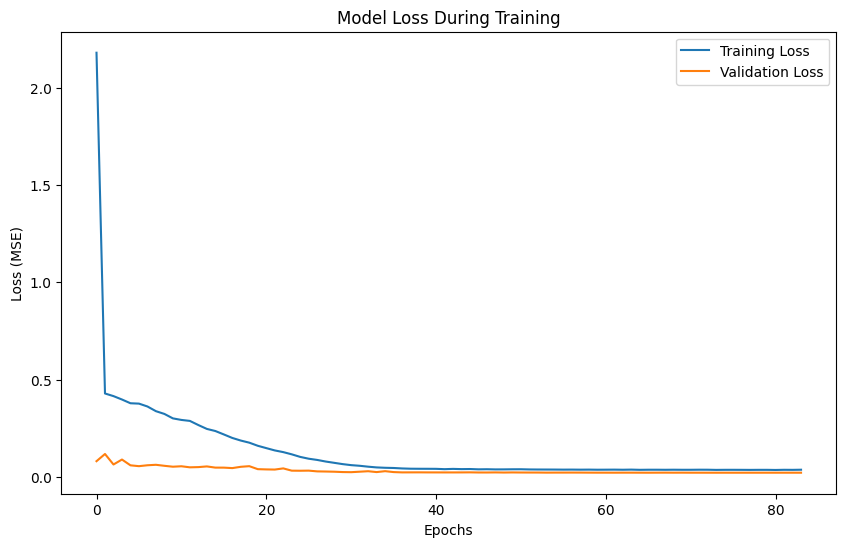

65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
Validation RMSE: 5.373395822500064


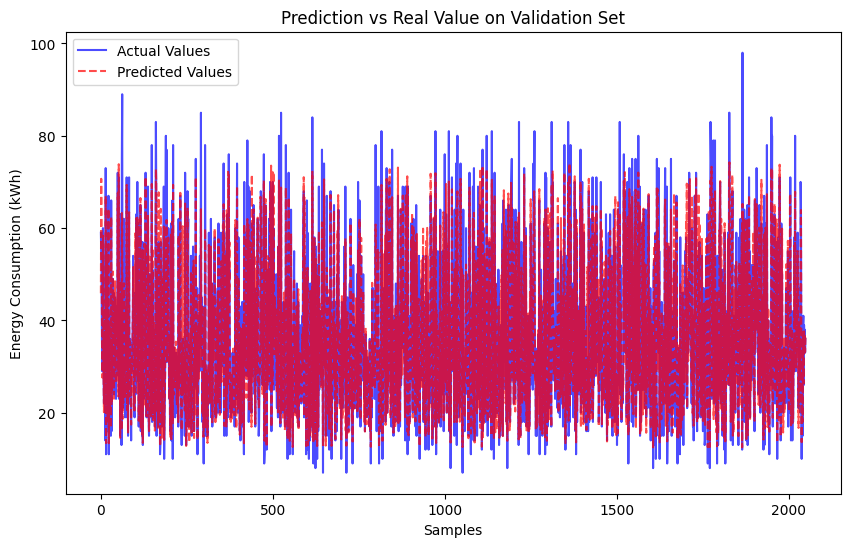

136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import mean_squared_error
import holidays

# Load the training and testing datasets
train = pd.read_csv("/kaggle/input/soai-lab-smart-home-energy-consumption-prediction/train_energy.csv")
test = pd.read_csv("/kaggle/input/soai-lab-smart-home-energy-consumption-prediction/test_energy.csv")

In [ ]:
# Strip any leading/trailing spaces from the column names
train.columns = train.columns.str.strip()
test.columns = test.columns.str.strip()

# Check the columns to ensure the correct column name
print(train.columns)
print(test.columns)


In [ ]:
# Ensure 'EnergyConsumption(kWh)' is present in the training data
if 'EnergyConsumption(kWh)' not in train.columns:
    raise KeyError("'EnergyConsumption(kWh)' column is missing in the training data")

# Convert 'DateTime' to datetime object to enable feature extraction
train['DateTime'] = pd.to_datetime(train['DateTime'])
test['DateTime'] = pd.to_datetime(test['DateTime'])


In [ ]:
# Feature engineering: Extract time-related features and add lag/rolling stats
def create_time_features(df, country='US', is_test=False):
    df['hour'] = df['DateTime'].dt.hour
    df['day_of_week'] = df['DateTime'].dt.dayofweek
    df['month'] = df['DateTime'].dt.month
    df['year'] = df['DateTime'].dt.year
    df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)
    
    us_holidays = holidays.CountryHoliday(country, years=df['DateTime'].dt.year.unique())
    df['is_holiday'] = df['DateTime'].dt.date.isin(us_holidays.keys()).astype(int)

    # Only create lag and rolling features for the training data
    if not is_test:
        df['lag_1'] = df['EnergyConsumption(kWh)'].shift(1)
        df['lag_7'] = df['EnergyConsumption(kWh)'].shift(7)
        df['rolling_mean_3'] = df['EnergyConsumption(kWh)'].rolling(window=3).mean()
        df['rolling_std_3'] = df['EnergyConsumption(kWh)'].rolling(window=3).std()

    return df

# Apply feature engineering to train and test datasets
train = create_time_features(train, country='US', is_test=False)
test = create_time_features(test, country='US', is_test=True)

In [ ]:
# Fill missing values caused by lag/rolling features in training data
train.bfill(inplace=True)  # Backward fill missing values

# Since the test data doesn't have 'EnergyConsumption(kWh)', we don't need to create lag features or rolling stats
test.bfill(inplace=True)


In [ ]:
# Separate features (X) and target variable (y) for training
X = train[['hour', 'day_of_week', 'month', 'year', 'is_weekend', 'is_holiday', 'lag_1', 'lag_7', 'rolling_mean_3', 'rolling_std_3']]
y = np.log1p(train['EnergyConsumption(kWh)'])  # Log-transform target variable

# Prepare test features (X_test) without the target variable
# Skip 'lag_1', 'lag_7', 'rolling_mean_3', 'rolling_std_3' for test data as they were not created
X_test = test[['hour', 'day_of_week', 'month', 'year', 'is_weekend', 'is_holiday']]

# Initialize the scaler for normalization
scaler = MinMaxScaler()

# Normalize the training features (excluding the lag/rolling features)
X_scaled = scaler.fit_transform(X[['hour', 'day_of_week', 'month', 'year', 'is_weekend', 'is_holiday']])

# Normalize the test features (using the same scaler, only for the common features)
X_test_scaled = scaler.transform(X_test[['hour', 'day_of_week', 'month', 'year', 'is_weekend', 'is_holiday']])

# Reshape input data for LSTM (samples, time steps, features)
X_scaled = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))
X_test_scaled = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

# Split the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


In [ ]:
# Build the Bidirectional LSTM model
model = Sequential([
    Bidirectional(LSTM(128, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True)),
    Dropout(0.4),
    Bidirectional(LSTM(64, activation='relu', return_sequences=False, dropout=0.2, recurrent_dropout=0.2)),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1)
])

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [ ]:
# Introduce Early Stopping and Learning Rate Scheduler
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-5)

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

In [ ]:
# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss During Training')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()


In [ ]:
# Make predictions on the validation set
y_pred = np.expm1(model.predict(X_val))  # Reverse log-transform
y_val_actual = np.expm1(y_val)  # Reverse log-transform

# Evaluate the model on the validation set using RMSE
rmse = np.sqrt(mean_squared_error(y_val_actual, y_pred))
print(f"Validation RMSE: {rmse}")


In [ ]:
# Plot predicted vs actual values on the validation set
plt.figure(figsize=(10, 6))
plt.plot(y_val_actual.values, label='Actual Values', color='blue', alpha=0.7)
plt.plot(y_pred, label='Predicted Values', color='red', linestyle='--', alpha=0.7)
plt.title('Prediction vs Real Value on Validation Set')
plt.xlabel('Samples')
plt.ylabel('Energy Consumption (kWh)')
plt.legend()
plt.show()

In [ ]:
# Make predictions on the test set
test['EnergyConsumption(kWh)'] = np.expm1(model.predict(X_test_scaled))

# Prepare the submission file for Kaggle
submission = test[['DateTime', 'EnergyConsumption(kWh)']]
submission.to_csv("/kaggle/working/new_submission.csv", index=False)